In [1]:
from numpy import log, sign
import numpy as np

from statsforecast import StatsForecast as sf
from statsforecast.models import MSTL
from datasetsforecast.m4 import M4

import seaborn as sb

c:\Users\Seraph\mambaforge\envs\forecasting\lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Data
---
Load in M4 hourly data. Just get the first 1 datasets.

In [2]:
df_all, *_ = M4.load('./data', 'Hourly')
df_all['ds'] = df_all['ds'].astype(int)

# Just pick out the first few datasets to work with.
n_series = 1
uids = df_all['unique_id'].unique()[:n_series]
df = df_all.query('unique_id in @uids').copy()

<Axes: xlabel='ds', ylabel='y'>

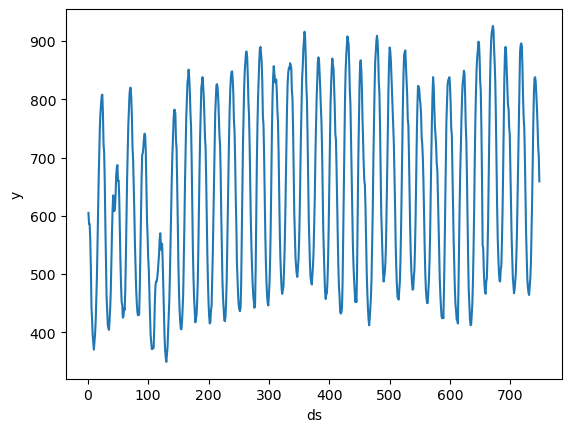

In [3]:
# Plot the raw data.
sb.lineplot(data=df, x='ds', y='y')

### Transformations
---

In [5]:
def boxcox(y, lambd):
    return log(y) if lambd==0 else lambd*(sign(y)*np.pow(np.abs(y), lambd) - 1)
    

### Moving Average
---
Doesn't seem to do a good job of removing the cycles. Edit: It seems like you have to really crank up the averaging parameter.

There's a funny intereaction when it comes to finding ways to smooth it out.
* 48->62 works well. Not more bumpy roads.
* 24->30 is pretty good too.
* 24->24.
* 24->12 is more kinky, but not bad.

Note: I'm so dumb, the top few and last entries will be NaN 😭.

<Axes: xlabel='ds', ylabel='y'>

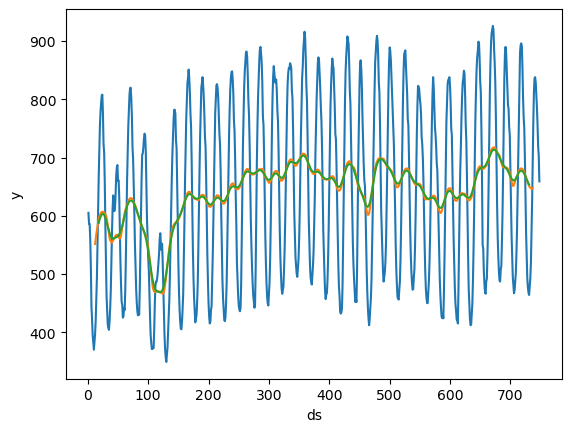

In [66]:
df['ma_5'] = df['y'].rolling(23, center=True).mean()
df['ma_5_5'] = df['ma_5'].rolling(13, center=True).mean()

sb.lineplot(data=df, x='ds', y='y')
sb.lineplot(data=df, x='ds', y='ma_5')
sb.lineplot(data=df, x='ds', y='ma_5_5')

<Axes: xlabel='ds', ylabel='detrended'>

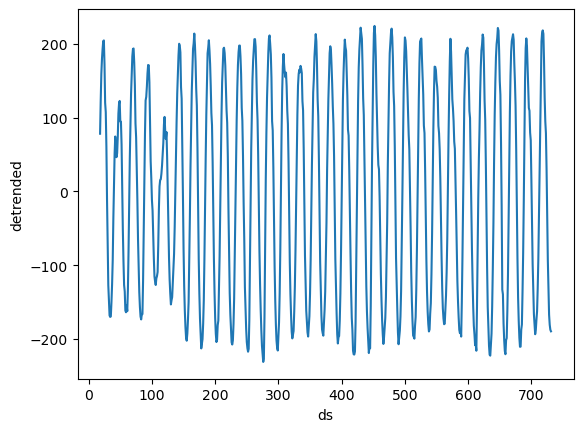

In [124]:
df['detrended'] = df['y'] - df['ma_5_5']

# From Chapter 2, M4-H01 has a season of every 10 hours.
seasons_length = 10
seasons = range(0, seasons_length)

ind_len = map(lambda i: (i, np.ceil((df.index.size - i)/seasons_length)), seasons)
indices = map(lambda pair: range(pair[0]+1, df.index.size, seasons_length), ind_len)
season_avg = map(lambda i_s: df['detrended'].iloc[list(i_s)].mean(), indices)

sb.lineplot(data=df, x='ds', y='detrended')

### STL Decomposition
---
I'm reading the seasonality plot wrong in Chapter 3. You pick a peak/valley and keep going forward until you hit it again. That length would be your season. In this case, just one for 24 hours.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

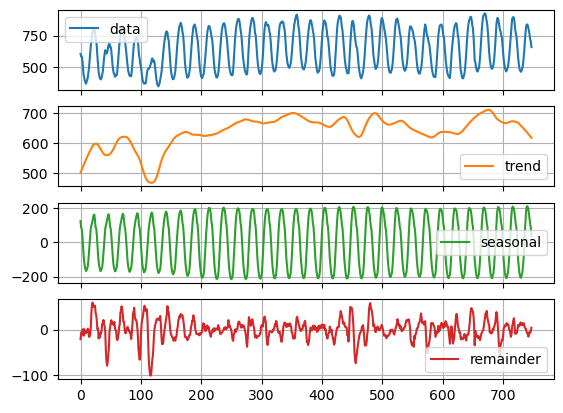

In [134]:
models = [MSTL(season_length=[24])]
decomp = sf(df = df, models=models, freq=1)
decomp.fit()

decomp.fitted_[0,0].model_.plot(subplots=True, grid=True)